In [30]:
!pip install pandas nltk scikit-learn openai python-dotenv networkx matplotlib pydub elevenlabs 

In [31]:
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np
import datetime

In [32]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [33]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4o', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [34]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Make sure there are always 3 elements in each tuple.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows, make sure the key is exactly: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    # Remove tuples with less than 3 elements
    for triplet in answer['List of triplets']:
        if len(triplet) < 3:
            answer['List of triplets'].remove(triplet)

    return answer

In [35]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg['List of triplets'])

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Check if there are edge labels
    if nx.get_edge_attributes(G, 'relation'):
        edge_labels = nx.get_edge_attributes(G, 'relation')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [36]:
def plot_highlighted_graph(kg, parsed_kg):
    ''' Plots graph based on knowledge graph with highlighted relevant nodes and edges '''
    G = nx.DiGraph()
    
    # Extract all triplets and relevant triplets
    all_triplets = set(tuple(triplet) for triplet in kg['List of triplets'])
    relevant_triplets = set(tuple(triplet) for triplet in parsed_kg['List of triplets'])
    
    # Add all triplets to the graph
    G.add_edges_from((source, target, {'relation': relation, 'color': 'gray'}) for source, relation, target in all_triplets)
    
    # Highlight relevant triplets
    for source, relation, target in relevant_triplets:
        if G.has_edge(source, target):
            G[source][target]['color'] = 'blue'
            G.nodes[source]['color'] = 'blue'
            G.nodes[target]['color'] = 'blue'
    
    # Plot the graph
    pos = nx.spring_layout(G, k=3, seed=0)
    
    # Draw nodes and edges with different colors
    node_colors = [G.nodes[node].get('color', 'lightgray') for node in G.nodes()]
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    plt.figure(figsize=(12, 8), dpi=300)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.axis('off')
    plt.show()

In [37]:
# Function to merge new triplets into the existing knowledge graph
def merge_knowledge_graphs(existing_kg, new_kg):
    existing_triplets = set(tuple(triplet) for triplet in existing_kg['List of triplets'])
    new_triplets = set(tuple(triplet) for triplet in new_kg['List of triplets'])
    merged_triplets = existing_triplets.union(new_triplets)
    return {'List of triplets': list(merged_triplets)}

In [38]:
def parse_knowledge_graph(kg, question):
    '''Parse knowledge graph to extract relevant relations'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": f'''You are a knowledge graph parser for the following knowledge graph {kg}. 
            Output the triplets that are relevant to the question. You want to maximize the retrieval of contextually relevant information.
            The final output should be in JSON as follows, make sure the key is exactly "List of triplets": {{"List of triplets": "List of triplets of the form (object1, relation, object2), type: list"}}'''},
            {"role": "user", "content": f"Here's the question: {question}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    # Remove tuples with less than 3 elements
    for triplet in answer['List of triplets']:
        if len(triplet) < 3:
            answer['List of triplets'].remove(triplet)

    return answer

In [39]:
# Initialize an empty knowledge graph or load from a saved state
existing_kg = {'List of triplets': []}

Create Knowledge graph

In [40]:
new_input = "The quick brown fox jumps over the lazy dog"

In [41]:
# Build knowledge graph from new input
new_kg = build_knowledge_graph(new_input)
print(new_kg)

{'List of triplets': [['fox', 'jumps over', 'dog']]}


In [42]:
# Merge the new knowledge graph into the existing one
merged_kg = merge_knowledge_graphs(existing_kg, new_kg)

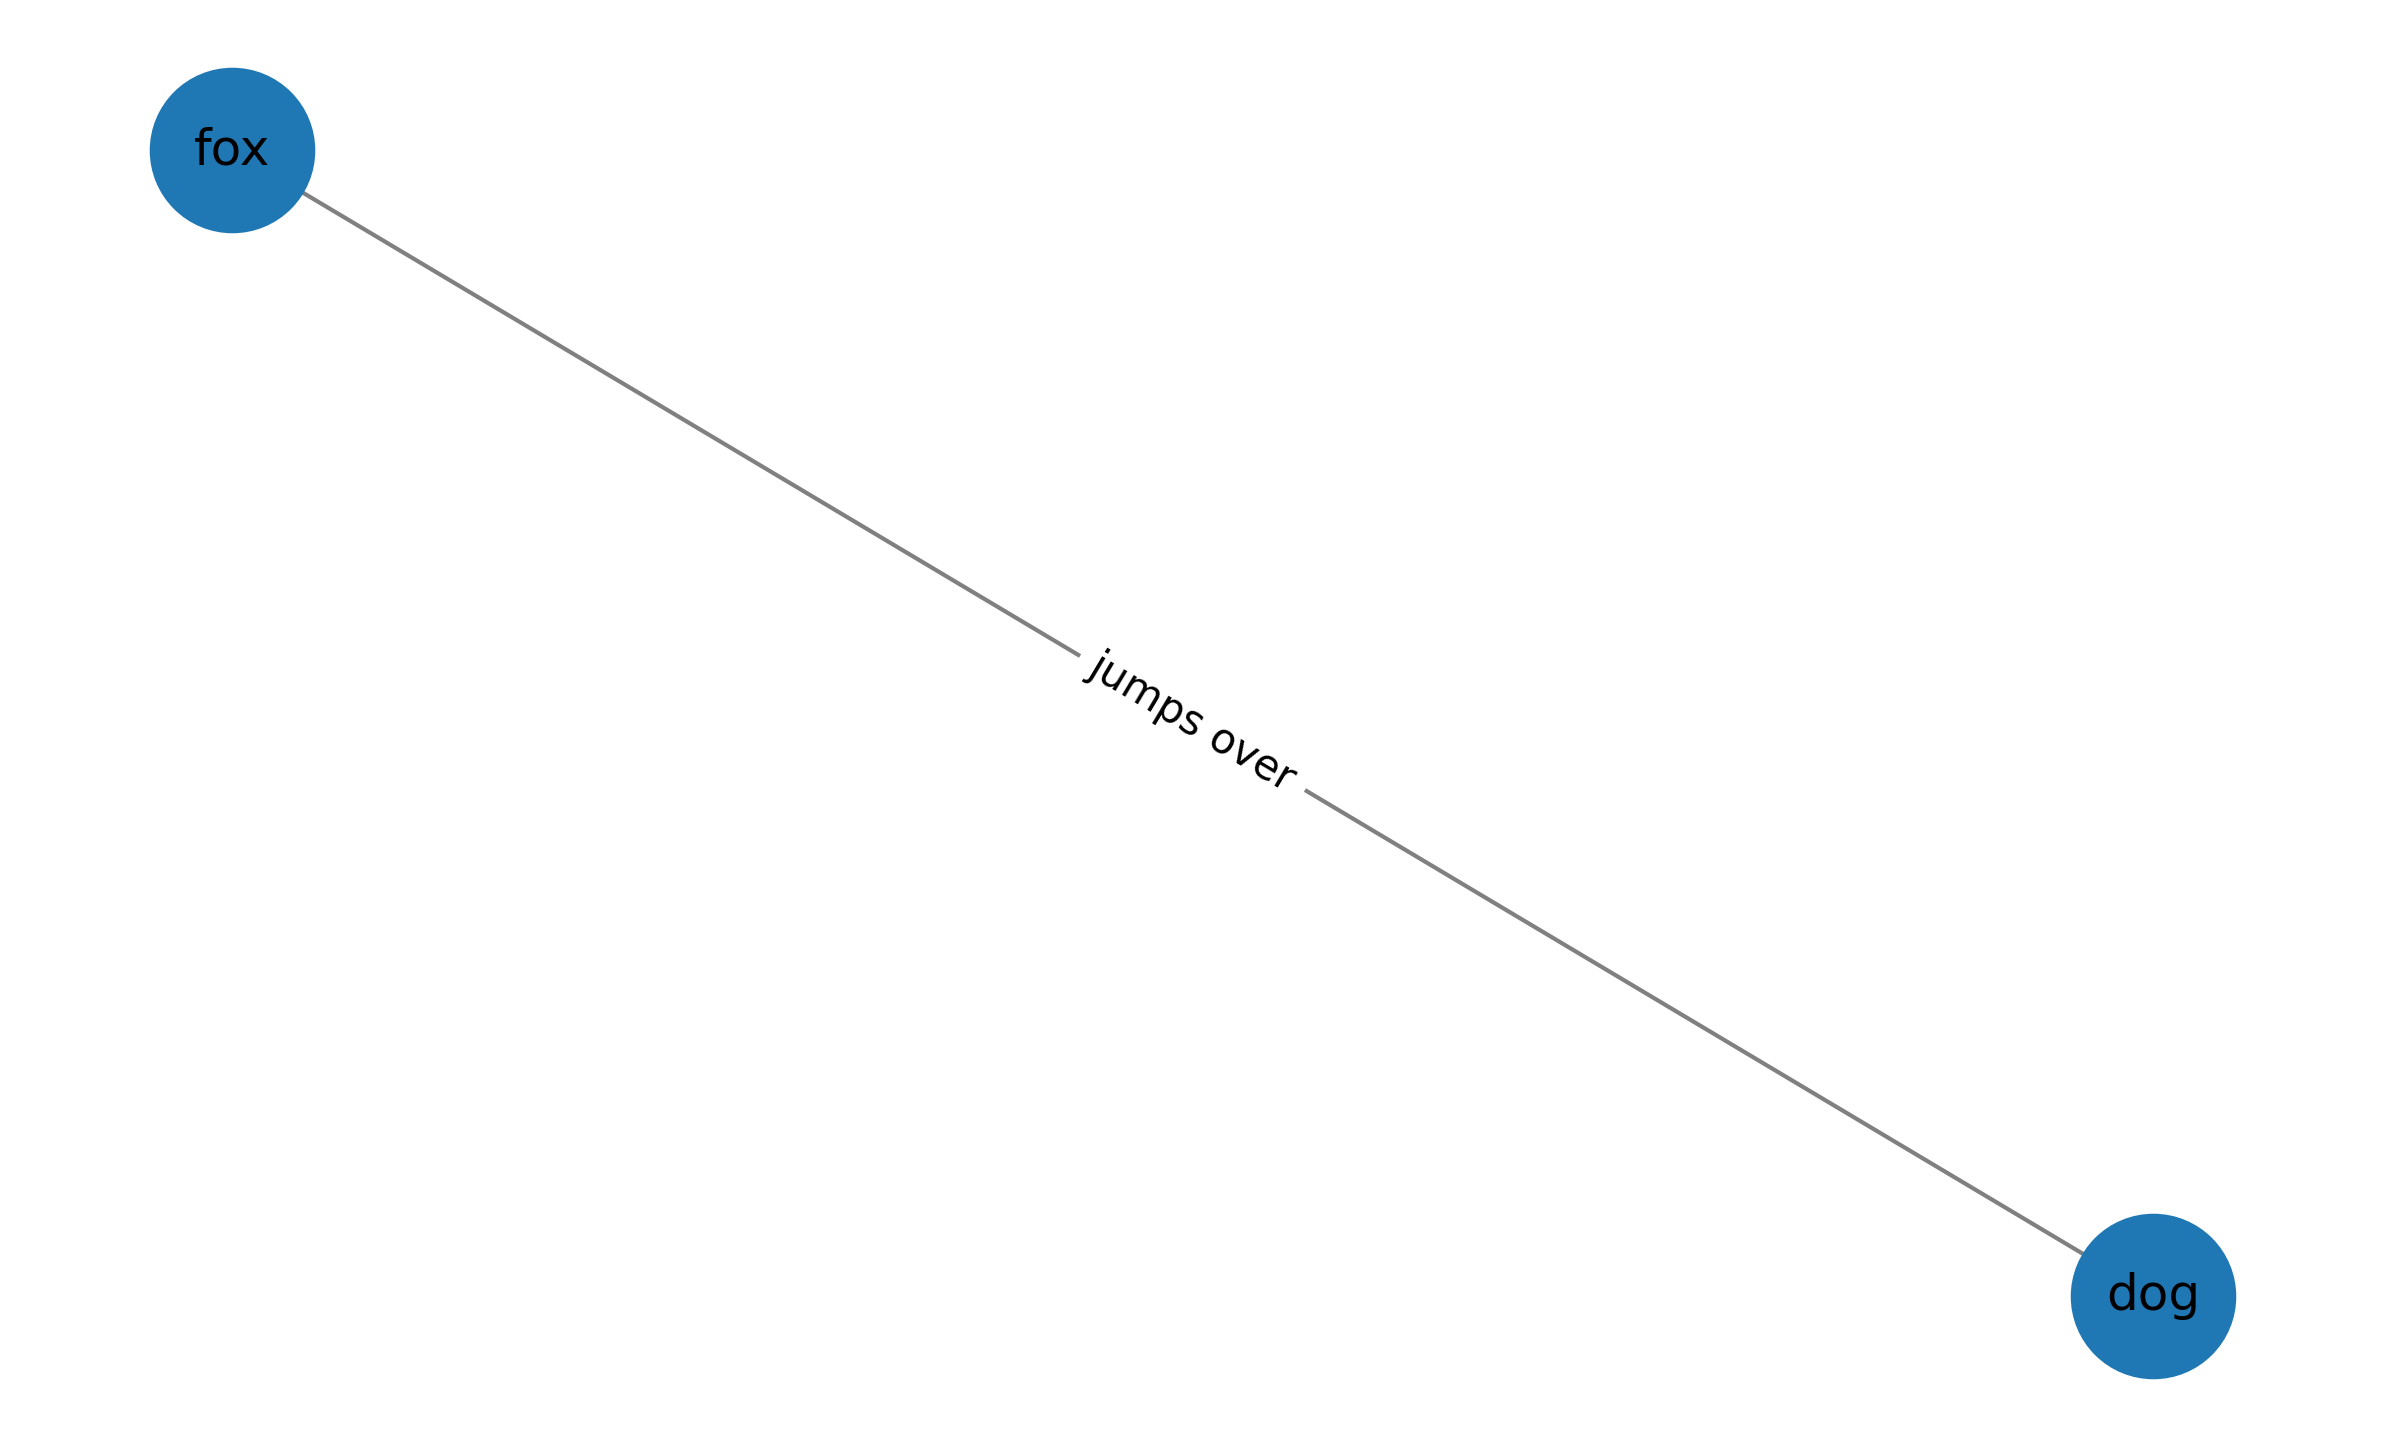

In [43]:
# Plot the updated knowledge graph
plot_graph(merged_kg)

In [44]:
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create the title with the datetime
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"

# Save the updated knowledge graph to a file
with open(f'saved_kgs/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)


Add info

In [45]:
new_input = " The lazy dog was sleeping on the porch"  

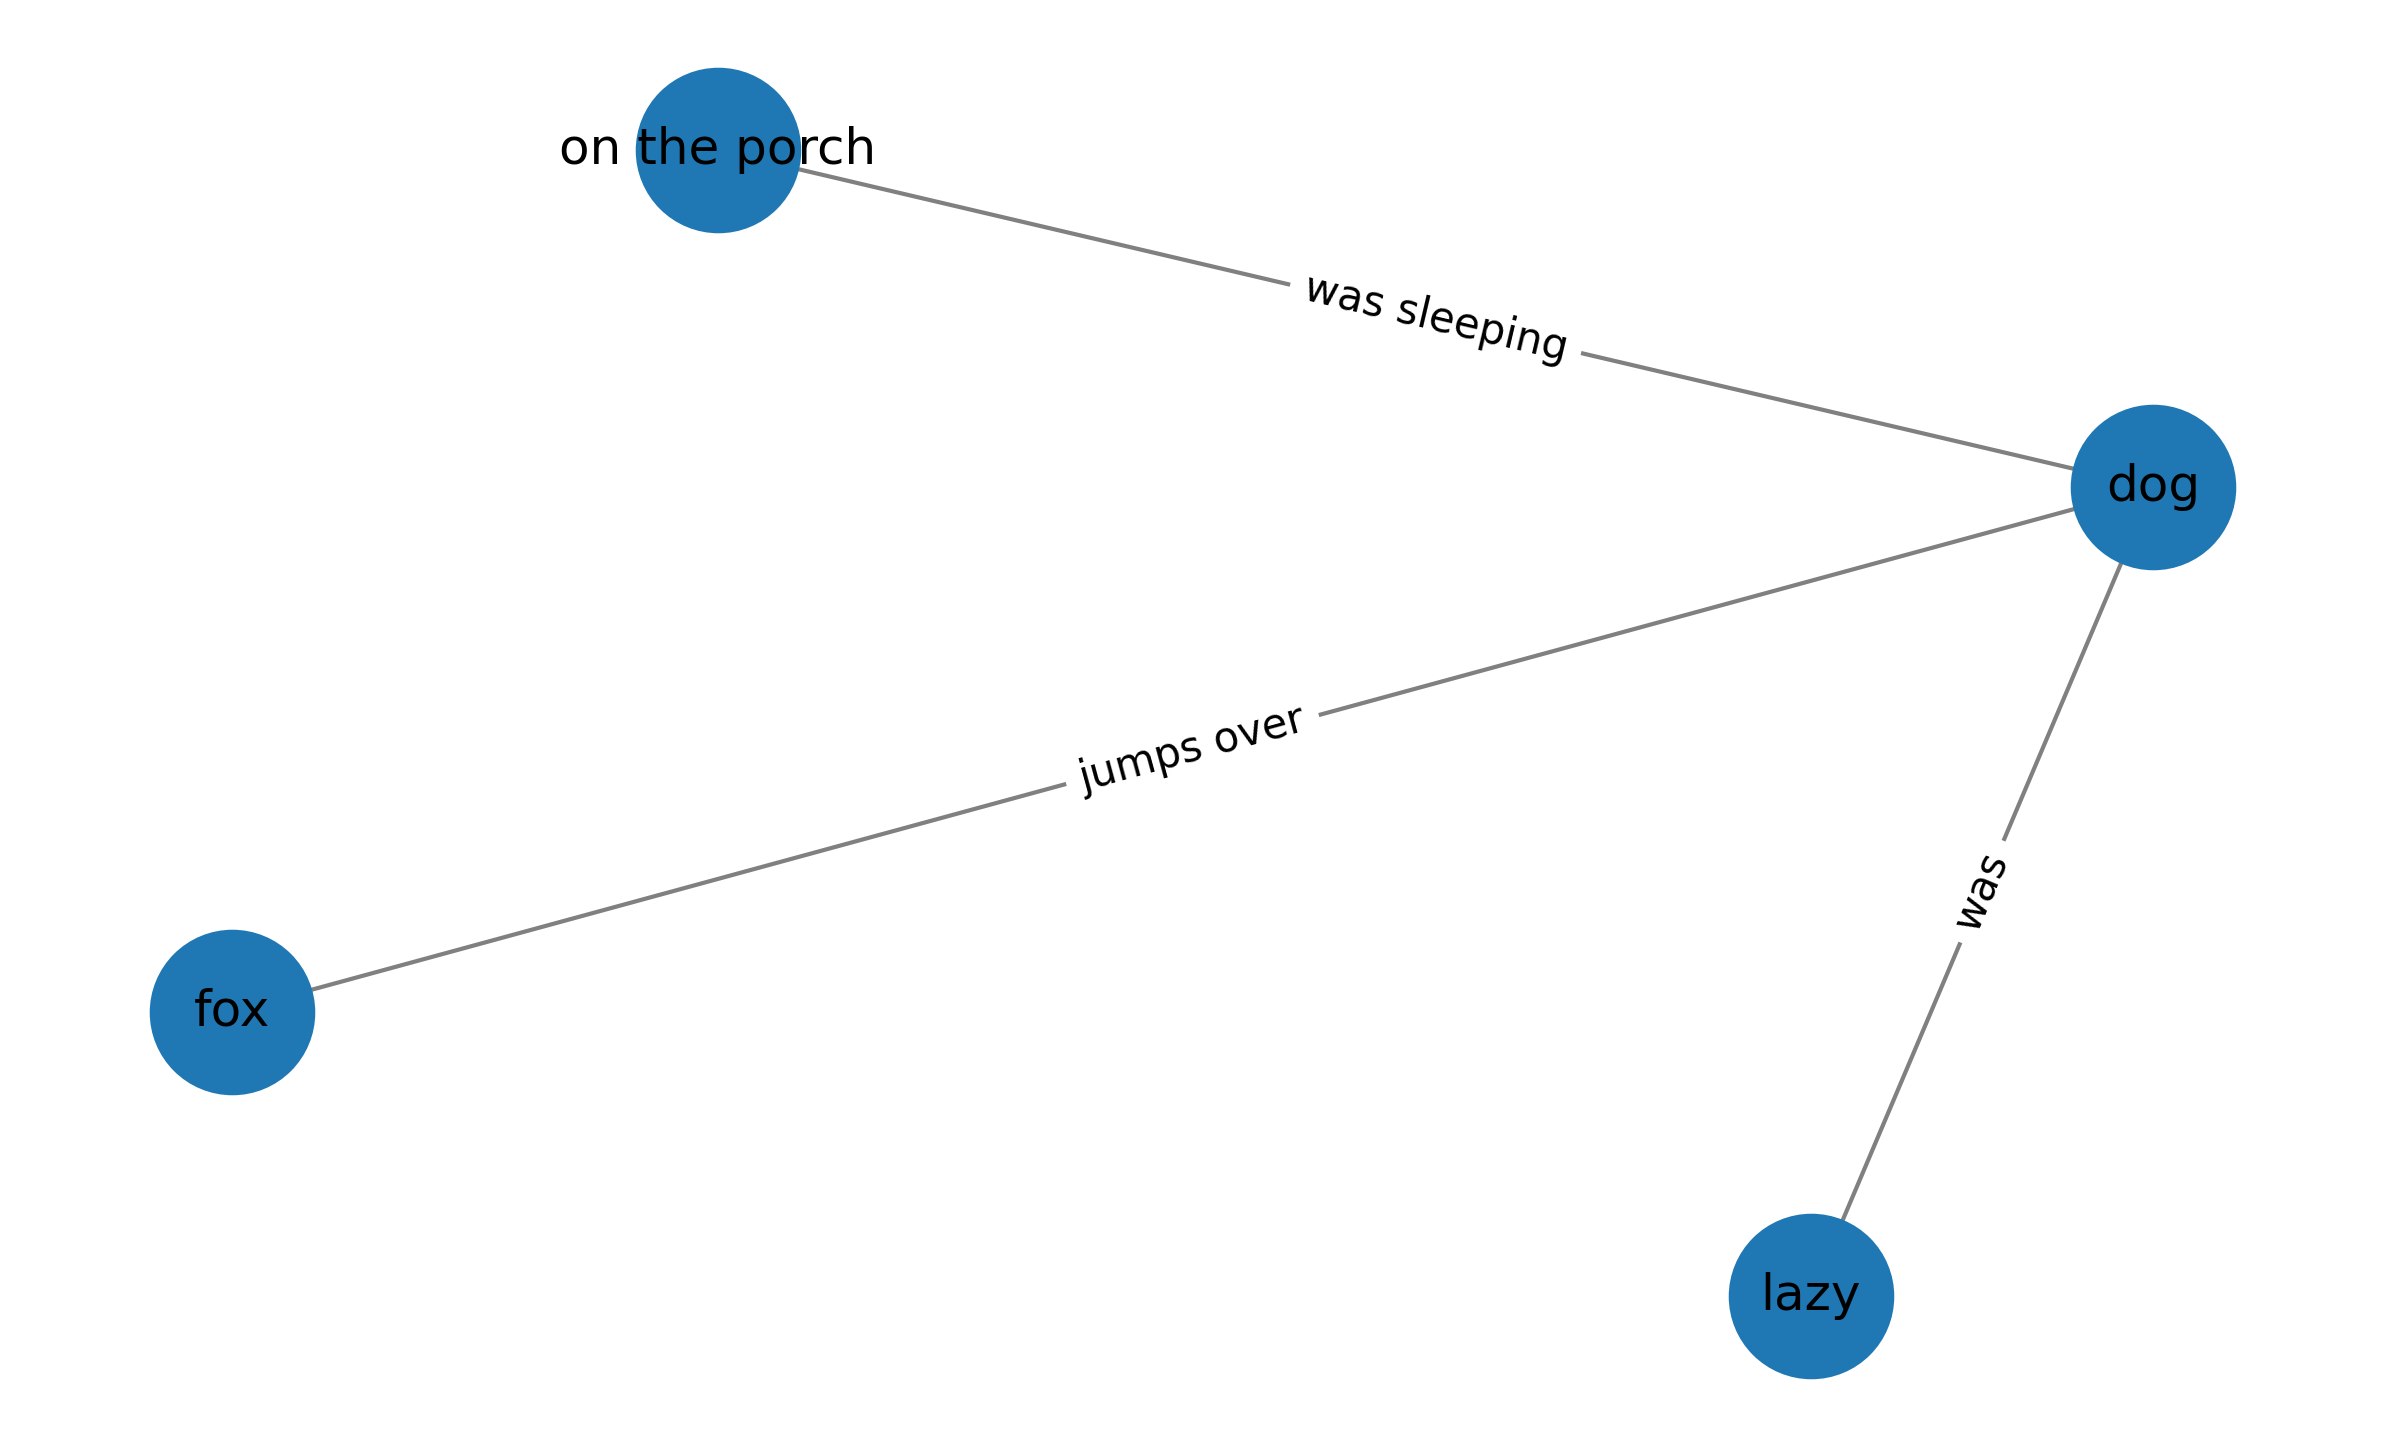

In [46]:
new_kg = build_knowledge_graph(new_input)
merged_kg = merge_knowledge_graphs(merged_kg, new_kg)
plot_graph(merged_kg)

In [47]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"
with open(f'saved_kgs/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)

Ask question

{'List of triplets': [['dog', 'was', 'lazy'], ['dog', 'was sleeping', 'on the porch']]}


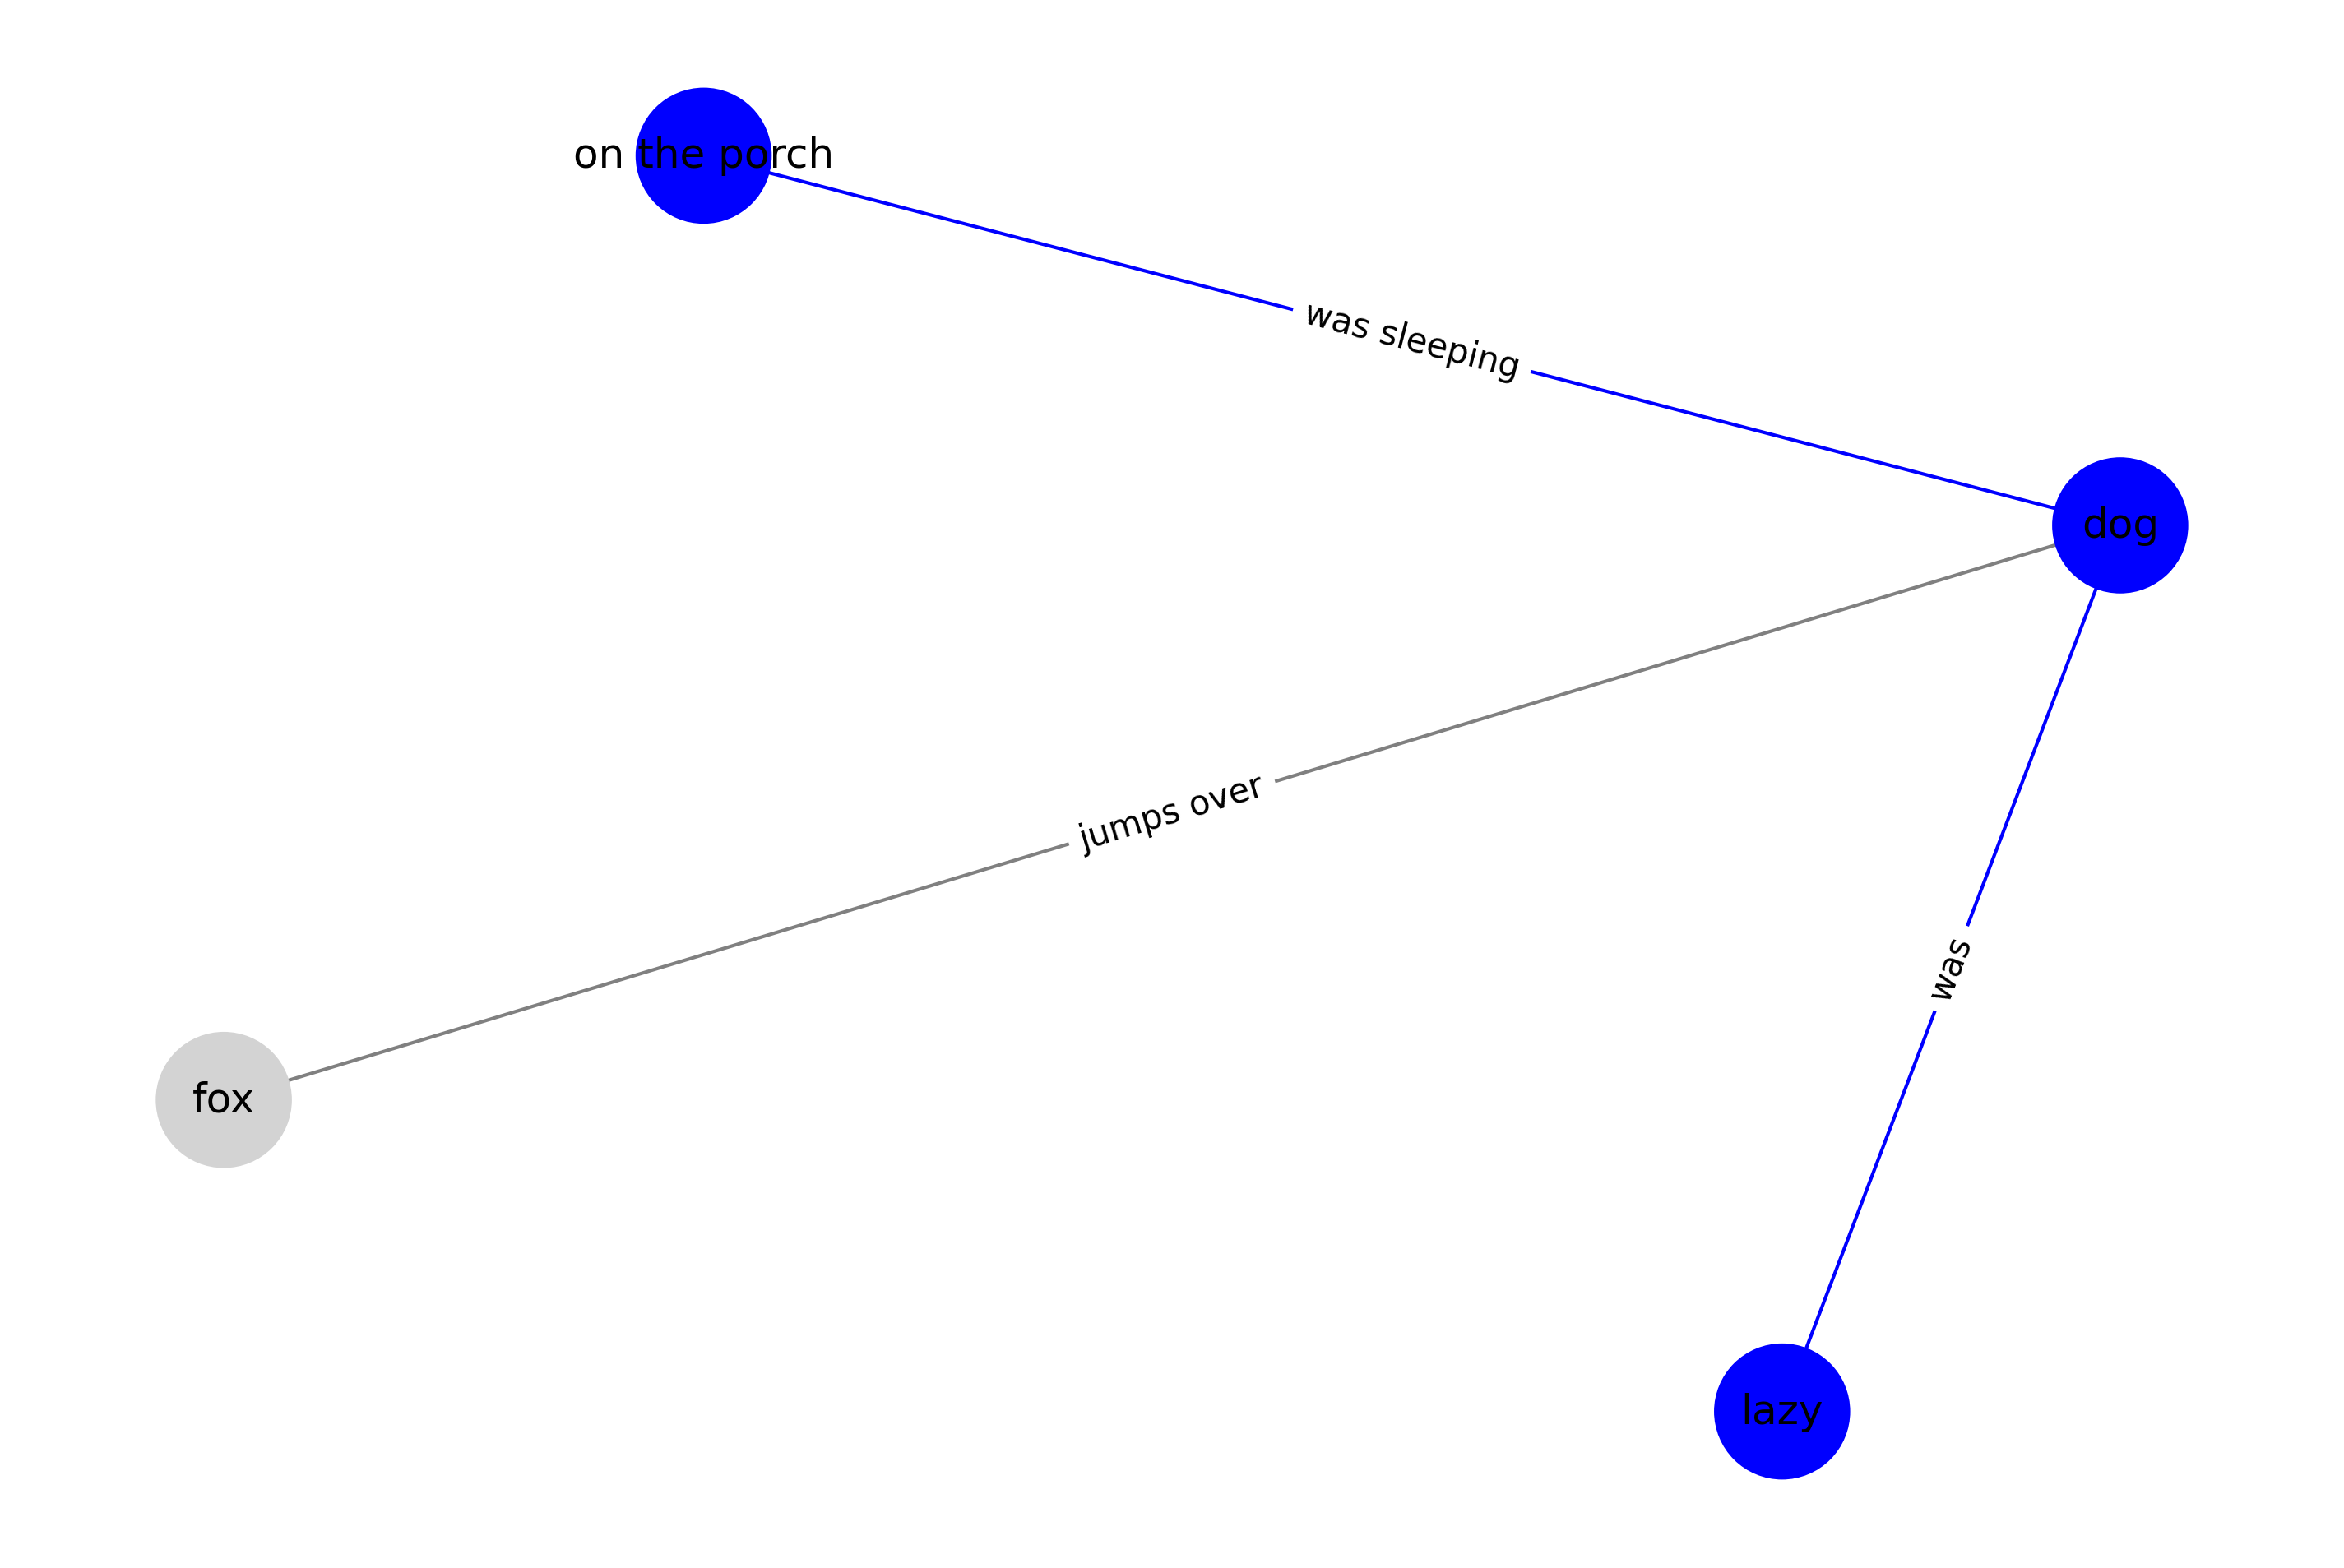

Response: The lazy dog was sleeping on the porch.


In [48]:
question = "What was the lazy dog doing?" 

# Parse knowledge graph to extract relevant relations
parsed_kg = parse_knowledge_graph(merged_kg, question)
print(parsed_kg)

# Plot the highlighted knowledge graph
plot_highlighted_graph(merged_kg, parsed_kg)

# Generate a response to a question based on the parsed knowledge graph
response = chat(f'''Use the following knowledge graph to answer the following question. Do not use external knowledge.
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg['List of triplets']}''',
                    user_prompt = f'''Question: {question}''')

print('Response:', response)

Add question

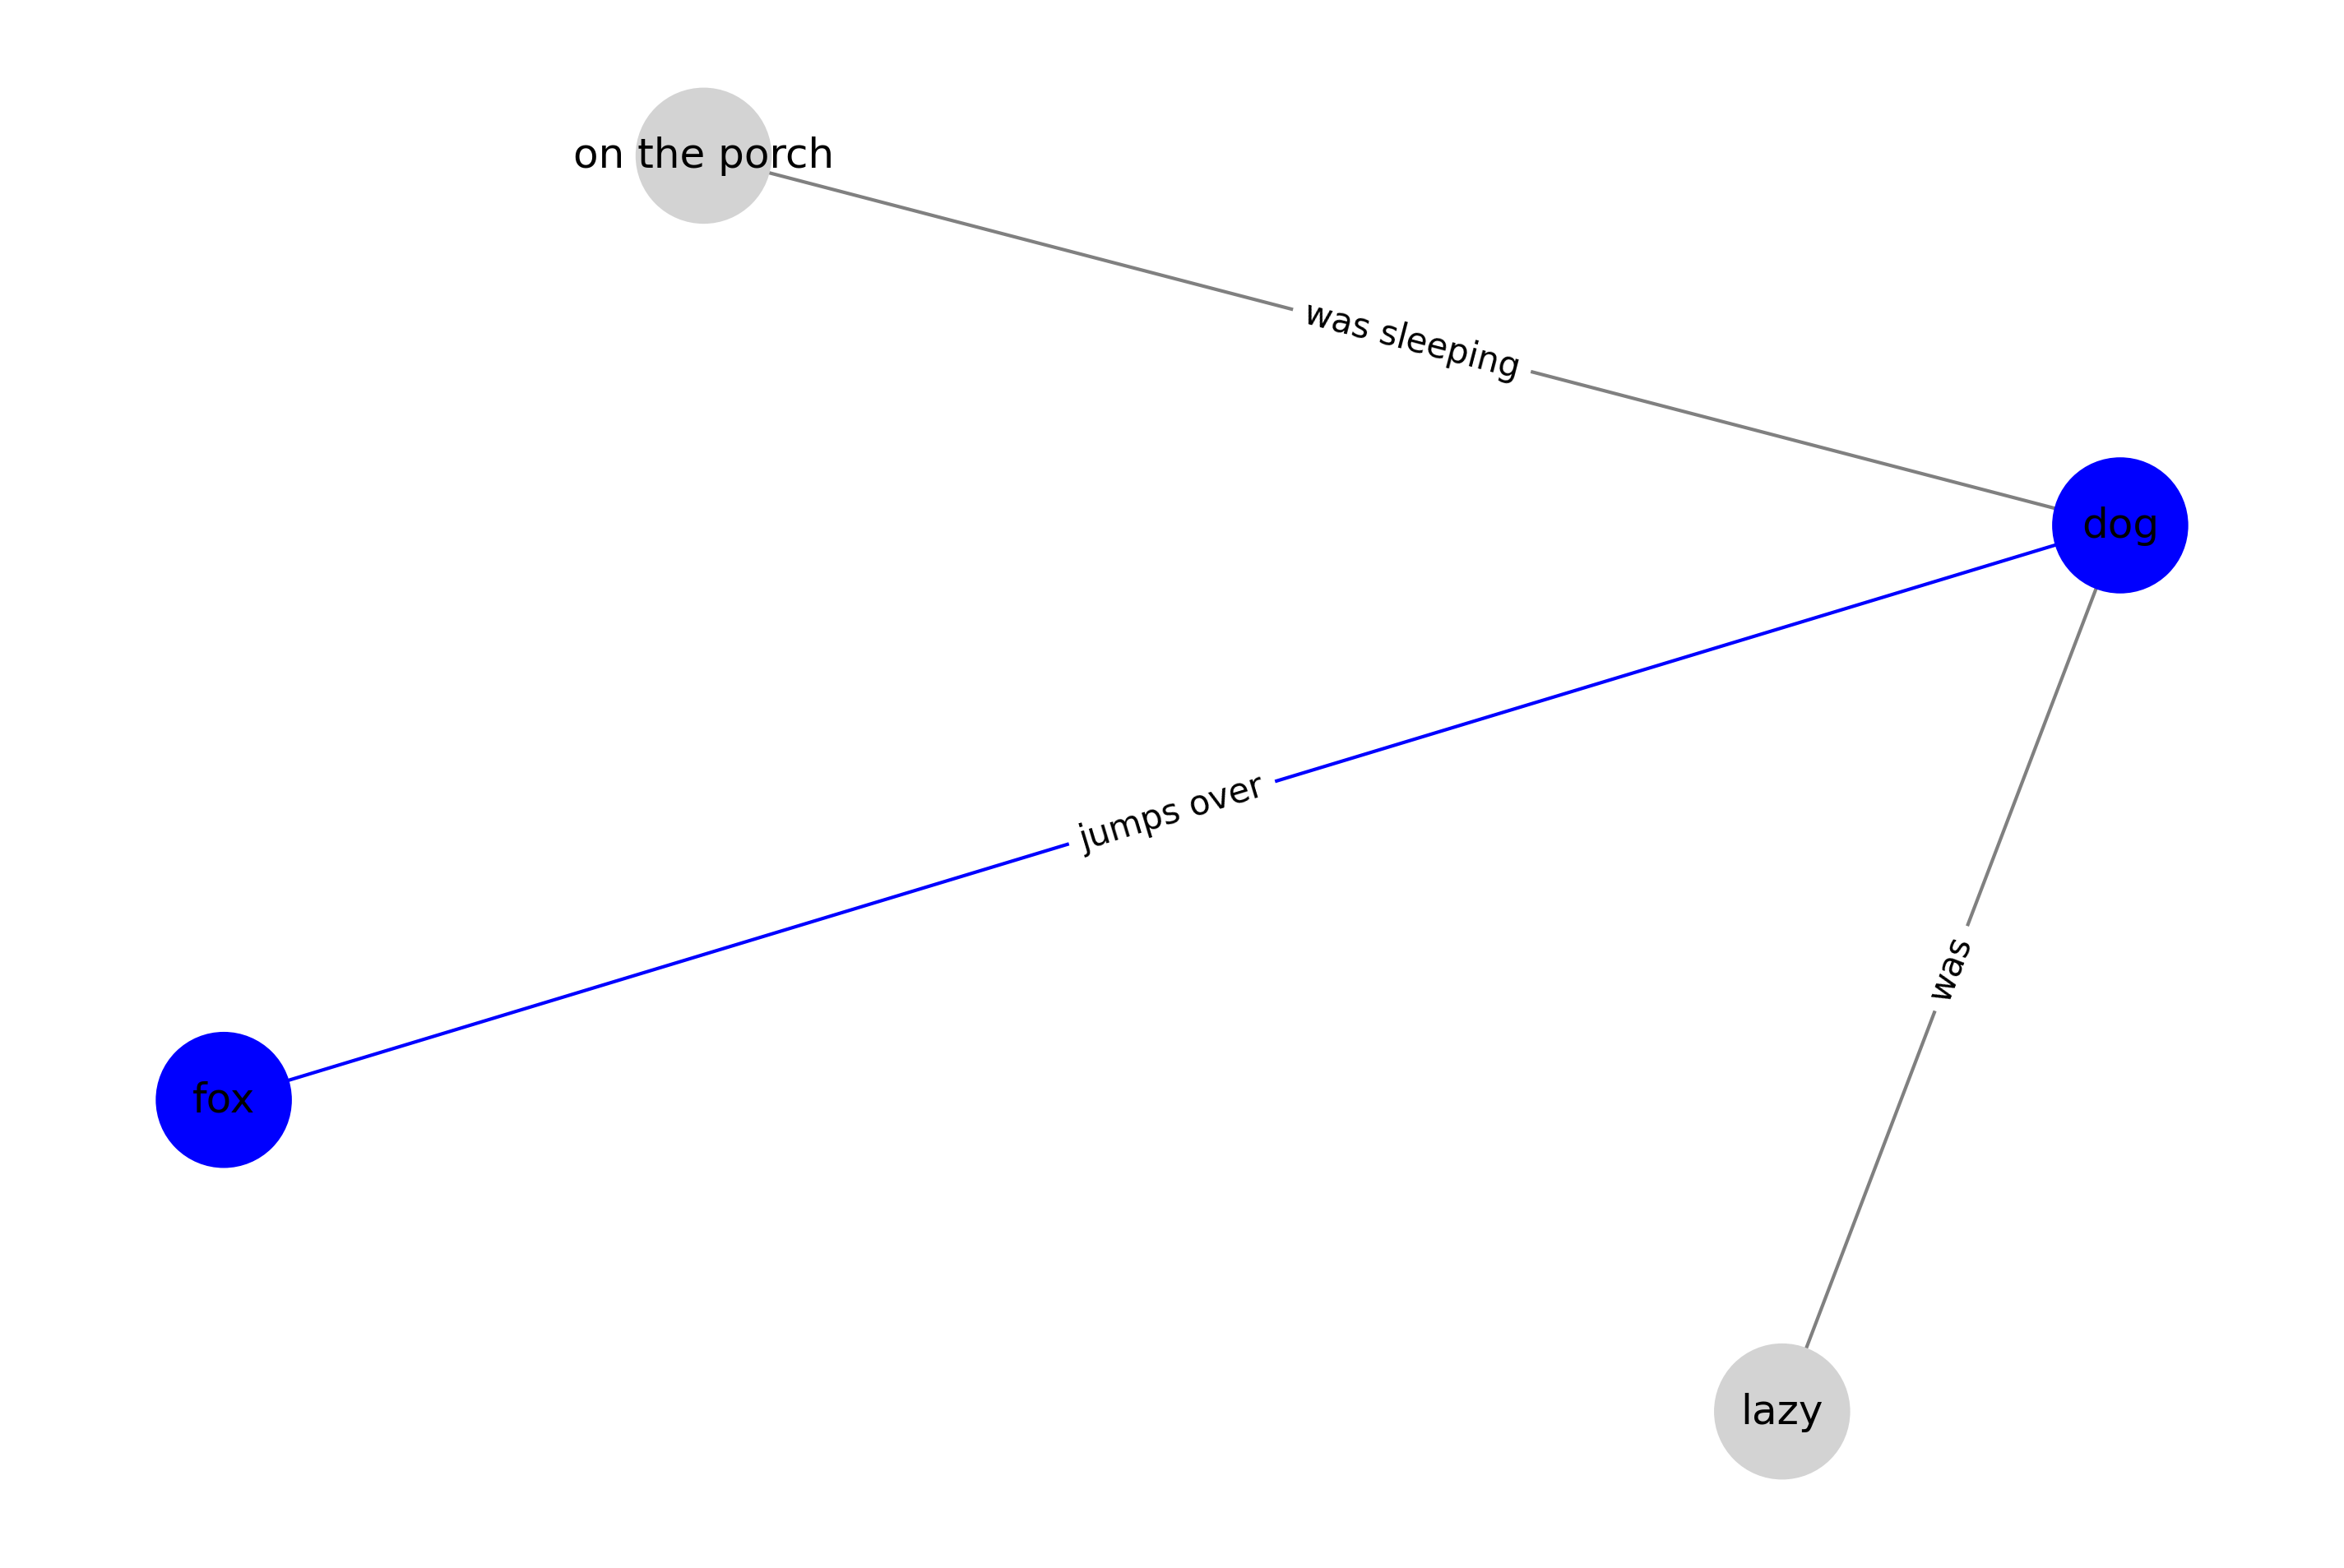

Response: No Info


In [49]:
question = "What was the quick brown fox doing?" 

# Parse knowledge graph to extract relevant relations
parsed_kg = parse_knowledge_graph(merged_kg, question)

# Plot the highlighted knowledge graph
plot_highlighted_graph(merged_kg, parsed_kg)

# Generate a response to a question based on the parsed knowledge graph
response = chat(f'''Use the following knowledge graph to answer the following question. Do not use external knowledge.
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg['List of triplets']}''',
                    user_prompt = f'''Question: {question}''')

print('Response:', response)